In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 988.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=cf66eeb55363030bf53fb5f5e9dd627cf0480452f5b3d9979bf619d739b97c28
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
### READ DATA ###
df=pd.read_csv('/content/drive/MyDrive/com_reviews_MP.csv',  sep=',')
column_to_drop = 'Unnamed: 0'
df = df.drop(column_to_drop, axis=1)
print(df.shape)
df

(4158, 2)


,Review_Text,Sentiment_Class
0,Bro njn 13 pro edukkan noknond suggestions??,Not_relevant
1,Tech inte ambassador 🤘😉🔥🔥🔥,Positive
2,Ivan aradey 😳,Negative
3,Bro 13 pro 256 gb green available anno,Neutral
4,samsung company ethra tharunundh,Neutral
...,...,...
4153,എന്നാൽ നിനക്ക് rs 5000 രൂപ സമ്മാനം relieved face,Not_relevant
4154,സുഹുർത്തെ tesla pi ഫോൺ ഇറങ്ങിയതോടെ apple i pho...,Mixed Feelings
4155,real me 10 pro vs redmi note 12 pro വീഡിയോ ചെയ...,Not_relevant
4156,ഇതിന്റെ google dailer and messaging app miui ട...,Neutral


In [ ]:
text=df['Review_Text']
labels=df['Sentiment_Class']

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from tqdm import tqdm
tqdm.pandas()
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
import copy
clean_texts=copy.deepcopy(text)
clean_texts

0            Bro njn 13 pro edukkan noknond suggestions??
1                              Tech inte ambassador 🤘😉🔥🔥🔥
2                                           Ivan aradey 😳
3                  Bro 13 pro 256 gb green available anno
4                        samsung company ethra tharunundh
                              ...                        
4153     എന്നാൽ നിനക്ക് rs 5000 രൂപ സമ്മാനം relieved face
4154    സുഹുർത്തെ tesla pi ഫോൺ ഇറങ്ങിയതോടെ apple i pho...
4155    real me 10 pro vs redmi note 12 pro വീഡിയോ ചെയ...
4156    ഇതിന്റെ google dailer and messaging app miui ട...
4157    എവിടെ backgroundil golden playbutton എവിടെ eye...
Name: Review_Text, Length: 4158, dtype: object

In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 4.1 MB/s eta 0:00:00


In [ ]:
import emoji
text1 = "game is on 🔥 🔥"
txt=emoji.demojize(text1, delimiters=("", ""))  # 'game is on fire fire'
# txt=':'+txt
# txt


In [ ]:
def emoji_text(text):
    # conv_text = ""
    conv_text = emoji.demojize(text)
    return conv_text

clean_texts= text.progress_apply(emoji_text)
clean_texts

100%|██████████| 4158/4158 [00:01<00:00, 3979.29it/s]


0            Bro njn 13 pro edukkan noknond suggestions??
1       Tech inte ambassador :sign_of_the_horns::winki...
2                              Ivan aradey :flushed_face:
3                  Bro 13 pro 256 gb green available anno
4                        samsung company ethra tharunundh
                              ...                        
4153     എന്നാൽ നിനക്ക് rs 5000 രൂപ സമ്മാനം relieved face
4154    സുഹുർത്തെ tesla pi ഫോൺ ഇറങ്ങിയതോടെ apple i pho...
4155    real me 10 pro vs redmi note 12 pro വീഡിയോ ചെയ...
4156    ഇതിന്റെ google dailer and messaging app miui ട...
4157    എവിടെ backgroundil golden playbutton എവിടെ eye...
Name: Review_Text, Length: 4158, dtype: object

In [ ]:
# Define a function to clean the code-mixed text while preserving the order
def clean_code_mixed_text(text):
    cleaned_text = ""
    current_language = None
    current_segment = ""

    # Iterate through each character in the input text
    for char in text:
        if re.match(r'[a-zA-Z]', char):
            if current_language == 'en' or current_language is None:
                current_segment += char
                current_language = 'en'
            else:
                cleaned_text += current_segment + ' '
                current_segment = char
                current_language = 'en'
        elif re.match(r'[ം-ൿ]', char):
            if current_language == 'ml' or current_language is None:
                current_segment += char
                current_language = 'ml'
            else:
                cleaned_text += current_segment + ' '
                current_segment = char
                current_language = 'ml'
        else:
            if current_segment:
                cleaned_text += current_segment + ' '
            current_segment = ""
            current_language = None

    # Add the last segment
    if current_segment:
        cleaned_text += current_segment

    return cleaned_text.strip()

cleaned_text = clean_texts.progress_apply(clean_code_mixed_text)
cleaned_text = cleaned_text.str.lower()

100%|██████████| 4158/4158 [00:00<00:00, 7652.40it/s]


In [ ]:
print("Cleaned Text:\n")
df_cleaned = pd.DataFrame(cleaned_text)
df_cleaned

Cleaned Text:



,Review_Text
0,bro njn pro edukkan noknond suggestions
1,tech inte ambassador sign of the horns winking...
2,ivan aradey flushed face
3,bro pro gb green available anno
4,samsung company ethra tharunundh
...,...
4153,എന്നാൽ നിനക്ക് rs രൂപ സമ്മാനം relieved face
4154,സുഹുർത്തെ tesla pi ഫോൺ ഇറങ്ങിയതോടെ apple i pho...
4155,real me pro vs redmi note pro വീഡിയോ ചെയ്യണേ ബ...
4156,ഇതിന്റെ google dailer and messaging app miui ട...


In [ ]:
import tensorflow as tf

# Set random seed for reproducibility
seed_value = 5
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
from keras.src.utils.np_utils import to_categorical
### SPLIT INTO TRAIN/TEST ###

y = to_categorical(df.Sentiment_Class.factorize()[0])

X_train, X_test, y_train, y_test = train_test_split(df_cleaned.Review_Text.tolist(), y, random_state=seed_value, test_size=0.15)

In [ ]:
### MAP LABEL ###

diz_label = {}
for i,label in enumerate(df.Sentiment_Class.factorize()[1]):
    diz_label[i] = label

diz_label

{0: 'Not_relevant',
 1: 'Positive',
 2: 'Negative',
 3: 'Neutral',
 4: 'Mixed Feelings'}

In [ ]:
### TRANSFORM ORIGINAL TEXT INTO SEQUENCES AND COMPUTE PADDING ###

max_len = 600

tokenizer = Tokenizer(lower=True, split=' ')
word_index = tokenizer.word_index
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(text)

# Padding sequences
padded_sequences = pad_sequences(sequences, maxlen=max_len)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)


(3534, 600) (624, 600)


In [ ]:
### TRAIN WORD2VEC###

# w2v=Word2Vec(vector_size=100, window=5, min_count=5, seed=33)
# w2v.build_vocab([s.split( ) for s in X_train])
# w2v.train([s.split( ) for s in X_train], total_examples=w2v.corpus_count, epochs=10)

In [ ]:
## TRAIN FASTTEXT ###
ft = FastText(vector_size=100, window=5, min_count=4, seed=33)
ft.build_vocab([s.split( ) for s in X_train])
ft.train([s.split( ) for s in X_train], total_examples=ft.corpus_count, epochs=10)

(340205, 542420)

In [ ]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM WORD2VEC ###

embedding_matrix_w2v = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():

    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        pas+=1

print('not in vocabulary', pas)

not in vocabulary 13052


In [ ]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM FASTTEXT ###

embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():

    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1

print('not in vocabulary', pas)
embedding_matrix_ft.shape

not in vocabulary 0


(13053, 100)

In [ ]:
### DEFINE INPUT LAYER FOR EMBEDDINGS READING AND CONCATENATION ###

### DEFINE INPUT LAYER FOR EMBEDDINGS READING AND CONCATENATION ###

def Concat_Emb(list_emb, maxlen):

    inputs = []
    output = []
    for embedding in list_emb:

        inp = Input(shape=(maxlen,))
        emb = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding], trainable=False)(inp)
        emb = Reshape((-1,100,1))(emb)
        inputs.append(inp)
        output.append(emb)

    concat = Concatenate(axis=-1)(output)

    return Model(inputs, concat)

In [ ]:
### TRY Concat_Emb ###
# read_emb = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
# read_emb.summary()

In [ ]:
### TRY Concat_Emb ###
read_emb = Concat_Emb([embedding_matrix_ft], maxlen=max_len)
read_emb.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 600, 100)          1305300   
                                                                 
 reshape_4 (Reshape)         (None, 600, 100, 1)       0         
                                                                 
 concatenate_2 (Concatenate  (None, 600, 100, 1)       0         
 )                                                               
                                                                 
Total params: 1305300 (4.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1305300 (4.98 MB)
_________________________________________________________________


In [ ]:

# def inputlayer(maxlen):

#     inp = Input(shape=(maxlen, 100, 2))
#     x = Reshape((maxlen, -1))(inp)
#     x = LSTM(2, return_sequences=True)(x)
#     x = Activation('sigmoid')(x)
#     x = Reshape((maxlen, 1, 2))(x)
#     x = multiply([inp, x])
#     out = Lambda(lambda t: K.sum(t, axis=-1))(x)

#     return Model(inp, out)

In [ ]:
def inputlayer(maxlen):

    inp = Input(shape=(maxlen, 100, 1))#600,100,1
    x = Reshape((maxlen, -1))(inp)#600,100
    x = GRU(1, return_sequences=True)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1,1))(x)#600,1,1
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)

    return Model(inp, out)

In [ ]:
    # inp = Input(shape=(max_len, 100, 1))#600,100,1
    # print(inp.shape)
    # x = Reshape((max_len, -1))(inp)#600,100
    # print(x.shape)
    # x = LSTM(1, return_sequences=True)(x)
    # x = Activation('sigmoid')(x)
    # print(x.shape)#600,2
    # x = Reshape((max_len, 1,1))(x)#600,1,1
    # print(x.shape)
    # x = multiply([inp, x])
    # print(x.shape)
    # out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    # print(out.shape)


In [ ]:
# Model building
### DEFINE NETWORK WITH DME ###

concat_inp = Concat_Emb([embedding_matrix_ft], maxlen=max_len)
modl =inputlayer(max_len)
x = modl(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)
model = Model(concat_inp.input, out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding (Embedding)       (None, 600, 100)          1305300   
                                                                 
 reshape (Reshape)           (None, 600, 100, 1)       0         
                                                                 
 concatenate (Concatenate)   (None, 600, 100, 1)       0         
                                                                 
 model_1 (Functional)        (None, 600, 100)          309       
                                                                 
 gru_1 (GRU)                 (None, 600, 128)          88320     
                                                                 
 gru_2 (GRU)                 (None, 32)                1555

In [ ]:
# Model training
history=model.fit([sequence_train]*1, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)


Epoch 1/20
25/25 - 22s - loss: 1.5234 - accuracy: 0.3327 - val_loss: 1.4593 - val_accuracy: 0.3842 - 22s/epoch - 864ms/step
Epoch 2/20
25/25 - 2s - loss: 1.4714 - accuracy: 0.3695 - val_loss: 1.4660 - val_accuracy: 0.3644 - 2s/epoch - 98ms/step
Epoch 3/20
25/25 - 3s - loss: 1.4533 - accuracy: 0.3736 - val_loss: 1.4382 - val_accuracy: 0.3729 - 3s/epoch - 120ms/step
Epoch 4/20
25/25 - 2s - loss: 1.4424 - accuracy: 0.3777 - val_loss: 1.4124 - val_accuracy: 0.3870 - 2s/epoch - 93ms/step
Epoch 5/20
25/25 - 2s - loss: 1.4268 - accuracy: 0.3884 - val_loss: 1.4067 - val_accuracy: 0.4153 - 2s/epoch - 63ms/step
Epoch 6/20
25/25 - 2s - loss: 1.4174 - accuracy: 0.3940 - val_loss: 1.3975 - val_accuracy: 0.4266 - 2s/epoch - 63ms/step
Epoch 7/20
25/25 - 2s - loss: 1.3981 - accuracy: 0.3984 - val_loss: 1.4027 - val_accuracy: 0.3983 - 2s/epoch - 63ms/step
Epoch 8/20
25/25 - 2s - loss: 1.3935 - accuracy: 0.4192 - val_loss: 1.3927 - val_accuracy: 0.3955 - 2s/epoch - 65ms/step
Epoch 9/20
25/25 - 2s - loss

In [ ]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)],
                            [diz_label[i] for i in np.argmax(model.predict([sequence_test]*1), axis=1)]))

20/20 [==============================] - 3s 42ms/step
                precision    recall  f1-score   support

Mixed Feelings       0.31      0.06      0.09        72
      Negative       0.48      0.09      0.16       118
       Neutral       0.44      0.52      0.48       147
  Not_relevant       0.43      0.58      0.50       156
      Positive       0.38      0.58      0.46       131

      accuracy                           0.42       624
     macro avg       0.41      0.37      0.34       624
  weighted avg       0.42      0.42      0.37       624



In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

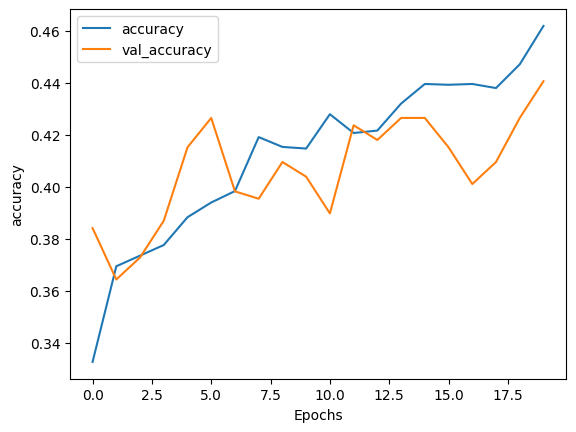

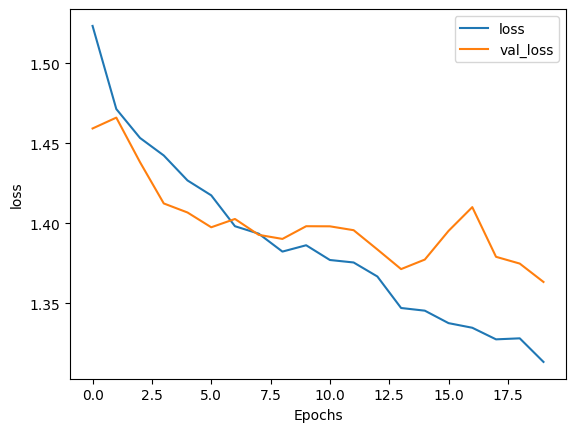

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")